# Quantum Fragility

/tmp/ipykernel_78274/1994241526.py:83: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(num_qubits, reps=fm_reps)
/tmp/ipykernel_78274/1994241526.py:84: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits, reps=ans_reps, entanglement="linear")
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
/tmp/ipykernel_78274/1994241526.py:83: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_


PHASE 1 (screen) — top candidates:
w=10, A=10 | score=1.12 ± 0.02
w= 8, A=12 | score=1.10 ± 0.02
w=12, A=10 | score=1.08 ± 0.07
w= 6, A=10 | score=1.05 ± 0.12
w= 6, A= 5 | score=1.03 ± 0.13
w=12, A= 7 | score=1.02 ± 0.01
w=10, A= 7 | score=1.01 ± 0.10
w=12, A= 5 | score=1.00 ± 0.01
w= 8, A= 7 | score=0.99 ± 0.05
w= 8, A= 5 | score=0.98 ± 0.19


/tmp/ipykernel_78274/1994241526.py:83: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(num_qubits, reps=fm_reps)
/tmp/ipykernel_78274/1994241526.py:84: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits, reps=ans_reps, entanglement="linear")
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
/tmp/ipykernel_78274/1994241526.py:83: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_


PHASE 2 (confirm) — final ranking:
w= 6, A= 5 | score=1.09 ± 0.16
w=12, A=10 | score=1.03 ± 0.02
w= 6, A=10 | score=0.97 ± 0.08
w=10, A=10 | score=0.95 ± 0.05
w= 8, A=12 | score=0.92 ± 0.02

Best config example: w=6, A=5 | score(seed0)=0.99
COBYLA budget used: maxiter=90 (num_weights=12)


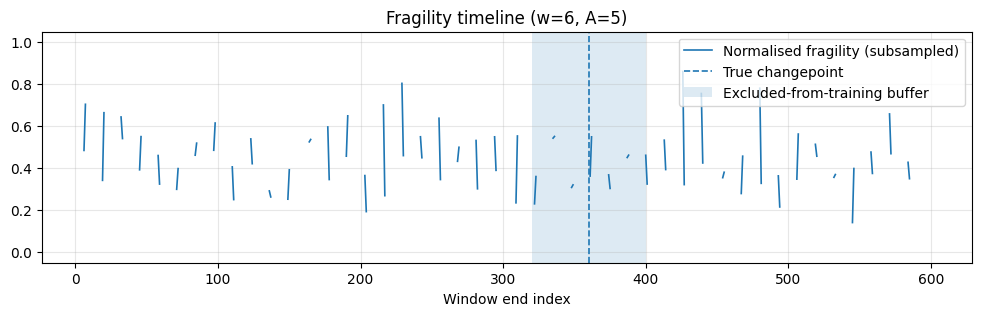


Total elapsed: 20055.2s


In [1]:
# ==================================================
# Representation Selection via Quantum Fragility
# - Two-phase workflow (screen -> confirm)
# - Batched finite-difference fragility (1 predict_proba per window)
# - Auto-fix COBYLA budget to avoid MAXFUN warnings
# - Optional memoization for predict_proba calls (off by default)
# ==================================================

import time
import numpy as np
import matplotlib.pyplot as plt

from pyts.approximation import SymbolicAggregateApproximation

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals


# -----------------------------
# 0) Synthetic dataset
# -----------------------------
def generate_series(seed=0, n=600, cp=360, noise=0.15, f1=1.0, f2=2.2):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 12 * np.pi, n)
    x = np.empty(n, dtype=float)
    x[:cp] = np.sin(f1 * t[:cp]) + noise * rng.standard_normal(cp)
    x[cp:] = np.sin(f2 * t[cp:]) + noise * rng.standard_normal(n - cp)
    return x, cp


# -----------------------------
# 1) Robust SAX -> int -> angle encoding
# -----------------------------
def sax_windows_to_angles(x, window_size, alphabet_size, strategy="quantile"):
    sax = SymbolicAggregateApproximation(n_bins=alphabet_size, strategy=strategy)
    sax_seq = sax.fit_transform(x.reshape(1, -1))[0]

    X_sax = np.array(
        [sax_seq[i : i + window_size] for i in range(len(sax_seq) - window_size)]
    )
    idx = np.arange(len(X_sax))
    end_idx = idx + window_size

    # Robust mapping (handles ints or strings)
    vocab = list(dict.fromkeys(sax_seq.tolist()))
    sym2int = {s: i for i, s in enumerate(vocab)}
    X_int = np.vectorize(sym2int.get)(X_sax).astype(int)

    X_angles = (2 * np.pi * X_int.astype(float) / alphabet_size).astype(float)
    return X_angles, end_idx


# -----------------------------
# 2) COBYLA budget guard
# -----------------------------
def _safe_cobyla_maxiter(requested_maxiter: int, num_weights: int) -> int:
    """
    SciPy COBYLA requires MAXFUN >= num_vars + 2.
    Qiskit exposes COBYLA(maxiter=...), which maps to a backend budget.
    This guard ensures we never trigger the "Invalid MAXFUN" warning.
    """
    min_budget = int(num_weights) + 2
    return max(int(requested_maxiter), min_budget)


# -----------------------------
# 3) Quantum classifier factory
# -----------------------------
def build_quantum_classifier(
    num_qubits,
    seed,
    maxiter=25,
    fm_reps=1,
    ans_reps=1,
):
    algorithm_globals.random_seed = seed
    np.random.seed(seed)

    feature_map = ZZFeatureMap(num_qubits, reps=fm_reps)
    ansatz = RealAmplitudes(num_qubits, reps=ans_reps, entanglement="linear")
    qc = feature_map.compose(ansatz)

    # COBYLA budget fix (only weight params are optimized)
    num_weights = len(ansatz.parameters)
    safe_maxiter = _safe_cobyla_maxiter(maxiter, num_weights)

    def interpret(bitstring_int: int) -> int:
        return 1 if bitstring_int.bit_count() > (num_qubits // 2) else 0

    qnn = SamplerQNN(
        circuit=qc,
        input_params=list(feature_map.parameters),
        weight_params=list(ansatz.parameters),
        sampler=StatevectorSampler(),
        interpret=interpret,
        output_shape=2,
    )

    optimizer = COBYLA(maxiter=safe_maxiter)
    clf = NeuralNetworkClassifier(qnn, optimizer=optimizer)

    return clf, {"safe_maxiter": safe_maxiter, "num_weights": num_weights}


# -----------------------------
# 4) Batched finite-difference fragility
# -----------------------------
def fragility_one_window_batched(x_vec, clf, eps=1e-3, cache=None):
    """
    ||grad_x p(y=1|x)||_2 via central differences.
    Critical speed trick: build all +/- perturbations and call predict_proba once.

    cache: optional dict for memoization, keyed by (x_vec.tobytes(), eps).
           Leave as None unless you know duplicates exist.
    """
    if cache is not None:
        key = (x_vec.tobytes(), float(eps))
        if key in cache:
            return cache[key]

    w = len(x_vec)
    Z = np.repeat(x_vec.reshape(1, -1), 2 * w, axis=0)

    # +eps for first w rows; -eps for next w rows
    rows = np.arange(w)
    Z[rows, rows] += eps
    Z[w + rows, rows] -= eps

    p = clf.predict_proba(Z)[:, 1]
    grad = (p[:w] - p[w:]) / (2 * eps)
    val = float(np.linalg.norm(grad, ord=2))

    if cache is not None:
        cache[key] = val
    return val


def fragility_subset_batched(X, clf, subset_idx, eps=1e-3, cache=None):
    out = np.full(len(X), np.nan, dtype=float)
    for j in subset_idx:
        out[j] = fragility_one_window_batched(X[j], clf, eps=eps, cache=cache)
    return out


# -----------------------------
# 5) Scoring function: near/far ratio
# -----------------------------
def fragility_localization_score(frag, end_idx, cp, near_radius=15, far_radius=120):
    dist = np.abs(end_idx - cp)
    near_mask = (dist < near_radius) & np.isfinite(frag)
    far_mask = (dist > far_radius) & np.isfinite(frag)

    if near_mask.sum() == 0 or far_mask.sum() == 0:
        return np.nan

    near = frag[near_mask].mean()
    far = frag[far_mask].mean()
    return float(near / (far + 1e-12))


# -----------------------------
# 6) Evaluate one config (fast + safe)
# -----------------------------
def evaluate_config_fast(
    window_size,
    alphabet_size,
    seed,
    *,
    n=600,
    cp=360,
    buffer=40,
    maxiter=25,
    frag_samples=120,
    eps=1e-3,
    near_radius=15,
    far_radius=120,
    sax_strategy="quantile",
    use_cache=False,
):
    x, cp = generate_series(seed=seed, n=n, cp=cp)
    X, end_idx = sax_windows_to_angles(
        x, window_size, alphabet_size, strategy=sax_strategy
    )
    y = (end_idx >= cp).astype(int)

    train_mask = (end_idx < (cp - buffer)) | (end_idx > (cp + buffer))
    X_train, y_train = X[train_mask], y[train_mask]

    if len(np.unique(y_train)) < 2:
        return np.nan, None, {"skipped": True}

    clf, meta = build_quantum_classifier(
        num_qubits=window_size,
        seed=seed,
        maxiter=maxiter,
        fm_reps=1,
        ans_reps=1,
    )
    clf.fit(X_train, y_train)

    if frag_samples >= len(X):
        subset_idx = np.arange(len(X), dtype=int)
    else:
        subset_idx = np.linspace(0, len(X) - 1, frag_samples, dtype=int)

    cache = {} if use_cache else None
    frag = fragility_subset_batched(X, clf, subset_idx=subset_idx, eps=eps, cache=cache)

    score = fragility_localization_score(
        frag, end_idx, cp, near_radius=near_radius, far_radius=far_radius
    )

    debug = {
        "frag": frag,
        "end_idx": end_idx,
        "cp": cp,
        "buffer": buffer,
        "subset_idx": subset_idx,
        "window": window_size,
        "alphabet": alphabet_size,
        "seed": seed,
    }
    return score, debug, meta


# -----------------------------
# 7) Phase 1: screening grid
# -----------------------------
def screen_grid(
    window_sizes,
    alphabet_sizes,
    seeds,
    *,
    maxiter=25,
    frag_samples=120,
    **eval_kwargs,
):
    results = []
    for w in window_sizes:
        for a in alphabet_sizes:
            scores = []
            for seed in seeds:
                s, _, _ = evaluate_config_fast(
                    w, a, seed, maxiter=maxiter, frag_samples=frag_samples, **eval_kwargs
                )
                scores.append(s)

            scores = np.array(scores, dtype=float)
            results.append(
                {
                    "window": w,
                    "alphabet": a,
                    "mean_score": np.nanmean(scores),
                    "std": np.nanstd(scores),
                }
            )
    return sorted(results, key=lambda r: -r["mean_score"])


# -----------------------------
# 8) Phase 2: confirm top-K
# -----------------------------
def confirm_topk(
    top_configs,
    seeds,
    *,
    maxiter=60,
    frag_samples=240,
    **eval_kwargs,
):
    results = []
    for cfg in top_configs:
        w, a = cfg["window"], cfg["alphabet"]
        scores = []
        for seed in seeds:
            s, _, _ = evaluate_config_fast(
                w, a, seed, maxiter=maxiter, frag_samples=frag_samples, **eval_kwargs
            )
            scores.append(s)

        scores = np.array(scores, dtype=float)
        results.append(
            {
                "window": w,
                "alphabet": a,
                "mean_score": np.nanmean(scores),
                "std": np.nanstd(scores),
            }
        )
    return sorted(results, key=lambda r: -r["mean_score"])


# -----------------------------
# 9) Plot helper
# -----------------------------
def plot_debug(debug, title="Fragility timeline"):
    frag = debug["frag"]
    end_idx = debug["end_idx"]
    cp = debug["cp"]
    buffer = debug["buffer"]

    norm = frag / (np.nanmax(frag) + 1e-12)

    plt.figure(figsize=(12, 3))
    plt.plot(end_idx, norm, linewidth=1.2, label="Normalised fragility (subsampled)")
    plt.axvline(cp, linestyle="--", linewidth=1.2, label="True changepoint")
    plt.axvspan(cp - buffer, cp + buffer, alpha=0.15, label="Excluded-from-training buffer")
    plt.ylim(-0.05, 1.05)
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.xlabel("Window end index")
    plt.legend()
    plt.show()


# ==================================================
# RUN: “good performance” long run (no MAXFUN warnings)
# ==================================================
if __name__ == "__main__":
    t0 = time.time()

    window_sizes = [6, 8, 10, 12]      # expand later once stable
    alphabet_sizes = [5, 7, 10, 12]    # slightly broader
    screen_seeds = [0, 1]              # stronger than seed=0 only

    # Phase 1 (screen)
    screen_results = screen_grid(
        window_sizes,
        alphabet_sizes,
        screen_seeds,
        maxiter=30,            # safe for all w<=12 (RealAmplitudes reps=1)
        frag_samples=120,
        sax_strategy="quantile",
        eps=1e-3,
        use_cache=False,
    )

    print("\nPHASE 1 (screen) — top candidates:")
    for r in screen_results[:10]:
        print(f"w={r['window']:2d}, A={r['alphabet']:2d} | score={r['mean_score']:.2f} ± {r['std']:.2f}")

    # confirm top-K
    K = 5
    top_configs = screen_results[:K]

    # Phase 2 (confirm)
    confirm_seeds = [0, 1, 2, 3]
    confirm_results = confirm_topk(
        top_configs,
        confirm_seeds,
        maxiter=90,            # robust training, still manageable
        frag_samples=260,
        sax_strategy="quantile",
        eps=1e-3,
        use_cache=False,
    )

    print("\nPHASE 2 (confirm) — final ranking:")
    for r in confirm_results:
        print(f"w={r['window']:2d}, A={r['alphabet']:2d} | score={r['mean_score']:.2f} ± {r['std']:.2f}")

    # Debug plot for best config (seed 0)
    best = confirm_results[0]
    best_score, best_debug, meta = evaluate_config_fast(
        best["window"],
        best["alphabet"],
        seed=0,
        maxiter=90,
        frag_samples=320,
        sax_strategy="quantile",
        eps=1e-3,
        use_cache=False,
    )
    print(f"\nBest config example: w={best['window']}, A={best['alphabet']} | score(seed0)={best_score:.2f}")
    print(f"COBYLA budget used: maxiter={meta['safe_maxiter']} (num_weights={meta['num_weights']})")

    if best_debug is not None:
        plot_debug(best_debug, title=f"Fragility timeline (w={best['window']}, A={best['alphabet']})")

    print(f"\nTotal elapsed: {time.time() - t0:.1f}s")


/tmp/ipykernel_78274/3506843612.py:83: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(num_qubits, reps=1)
/tmp/ipykernel_78274/3506843612.py:84: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits, reps=1, entanglement="linear")
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Training done. COBYLA maxiter used: 120 (num_weights=24)

Mean fragility by distance-to-changepoint band (end index):
  [  0,  10) : 35.9663
  [ 10,  20) : 32.8890
  [ 20,  40) : 30.7121
  [ 40,  80) : 35.4197
  [ 80, 160) : 34.0743

Near/Far localisation ratio (near<15, far>120): 1.099
Near mean=36.3770 | Far mean=33.0958


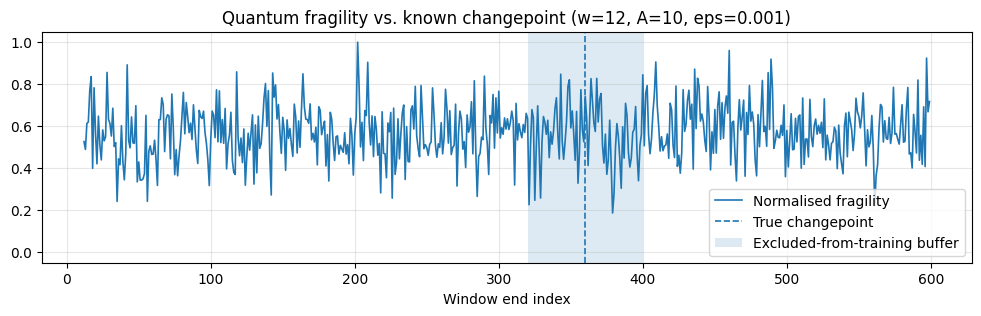


Top fragility windows (restricted to dist<40):
end=343 dist= 17 y=0 frag=49.7688 window=['i' 'h' 'j' 'i' 'h' 'g' 'i' 'h' 'i' 'g' 'g' 'g']
end=368 dist=  8 y=1 frag=48.6030 window=['e' 'c' 'd' 'c' 'd' 'd' 'e' 'f' 'f' 'f' 'g' 'f']
end=364 dist=  4 y=1 frag=48.5490 window=['e' 'e' 'e' 'd' 'e' 'c' 'd' 'c' 'd' 'd' 'e' 'f']
end=349 dist= 11 y=0 frag=48.2164 window=['i' 'h' 'i' 'g' 'g' 'g' 'g' 'g' 'f' 'g' 'e' 'e']
end=348 dist= 12 y=0 frag=46.3584 window=['g' 'i' 'h' 'i' 'g' 'g' 'g' 'g' 'g' 'f' 'g' 'e']
end=357 dist=  3 y=0 frag=45.4364 window=['f' 'g' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'd' 'e']
end=371 dist= 11 y=1 frag=44.3906 window=['c' 'd' 'd' 'e' 'f' 'f' 'f' 'g' 'f' 'g' 'g' 'i']
end=360 dist=  0 y=1 frag=43.6049 window=['e' 'e' 'e' 'e' 'e' 'e' 'e' 'd' 'e' 'c' 'd' 'c']
end=340 dist= 20 y=0 frag=43.1901 window=['j' 'i' 'j' 'i' 'h' 'j' 'i' 'h' 'g' 'i' 'h' 'i']
end=370 dist= 10 y=1 frag=42.8688 window=['d' 'c' 'd' 'd' 'e' 'f' 'f' 'f' 'g' 'f' 'g' 'g']
end=365 dist=  5 y=1 frag=42.4524 window=[

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyts.approximation import SymbolicAggregateApproximation

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals


# -----------------------------
# 0) Reproducibility
# -----------------------------
SEED = 12345
algorithm_globals.random_seed = SEED
rng = np.random.default_rng(SEED)
np.random.seed(SEED)  # ensure classical parts reproducible too


# -----------------------------
# 1) Synthetic series with a known changepoint
# -----------------------------
num_samples = 600
t = np.linspace(0, 12 * np.pi, num_samples)

cp = 360
noise = 0.15

x = np.empty(num_samples, dtype=float)
x[:cp] = np.sin(1.0 * t[:cp]) + noise * rng.standard_normal(cp)
x[cp:] = np.sin(2.2 * t[cp:]) + noise * rng.standard_normal(num_samples - cp)


# -----------------------------
# 2) SAX + sliding windows (use "safe" baseline from your earlier screens)
# -----------------------------
# Using A=10, w=12 tended to be the most stable in confirm runs.
n_bins = 10
window_size = 12

sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy="quantile")
sax_seq = sax.fit_transform(x.reshape(1, -1))[0]

X_sax = np.array([sax_seq[i : i + window_size] for i in range(num_samples - window_size)])
idx = np.arange(len(X_sax))  # window start indices

# Label each window by which regime its *end* belongs to
end_idx = idx + window_size
y_regime = (end_idx >= cp).astype(int)


# -----------------------------
# 3) Symbol -> angle encoding (robust mapping, avoids any dtype/version surprises)
# -----------------------------
# Works whether sax_seq is ints or letters.
vocab = list(dict.fromkeys(sax_seq.tolist()))
sym2int = {s: i for i, s in enumerate(vocab)}
X_int = np.vectorize(sym2int.get)(X_sax).astype(int)
X_angles = (2 * np.pi * X_int.astype(float) / n_bins).astype(float)


# -----------------------------
# 4) Train ONLY on "clean" windows far from the changepoint
# -----------------------------
buffer = 40
train_mask = (end_idx < (cp - buffer)) | (end_idx > (cp + buffer))

X_train = X_angles[train_mask]
y_train = y_regime[train_mask]

if len(np.unique(y_train)) < 2:
    raise ValueError("Degenerate training set (only one class). Reduce buffer or change cp/window_size.")


# -----------------------------
# 5) Quantum classifier (budget-safe COBYLA)
# -----------------------------
num_qubits = window_size

feature_map = ZZFeatureMap(num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement="linear")
qc = feature_map.compose(ansatz)

# Binary reduction of bitstrings: "more than half ones" -> class 1
def interpret(bitstring_int: int) -> int:
    return 1 if bitstring_int.bit_count() > (num_qubits // 2) else 0

qnn = SamplerQNN(
    circuit=qc,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
    sampler=StatevectorSampler(),
    interpret=interpret,
    output_shape=2,
)

# COBYLA: avoid SciPy "Invalid MAXFUN" by ensuring >= num_weights + 2
num_weights = len(ansatz.parameters)
maxiter_requested = 120              # you said you have time; stabilise optimisation
maxiter_safe = max(maxiter_requested, num_weights + 2)

clf = NeuralNetworkClassifier(qnn, optimizer=COBYLA(maxiter=maxiter_safe))
clf.fit(X_train, y_train)

print(f"Training done. COBYLA maxiter used: {maxiter_safe} (num_weights={num_weights})")


# -----------------------------
# 6) Fragility: ||grad_x p(class=1|x)|| via finite differences (BATCHED)
# -----------------------------
def fragility_batched(x_vec, clf, eps=1e-3):
    """
    Central differences with a single predict_proba call:
    Z has shape (2*w, w), containing all x +/- eps e_i.
    """
    w = len(x_vec)
    Z = np.repeat(x_vec.reshape(1, -1), 2 * w, axis=0)

    rows = np.arange(w)
    Z[rows, rows] += eps
    Z[w + rows, rows] -= eps

    p = clf.predict_proba(Z)[:, 1]  # p(y=1|z)
    grad = (p[:w] - p[w:]) / (2 * eps)
    return float(np.linalg.norm(grad, ord=2))

eps = 1e-3

# Full computation on ALL windows is expensive but you said you have time.
frag = np.array([fragility_batched(xv, clf, eps=eps) for xv in X_angles], dtype=float)


# -----------------------------
# 7) Evaluate: does fragility concentrate near changepoint?
# -----------------------------
dist_to_cp = np.abs(end_idx - cp)

bands = [0, 10, 20, 40, 80, 160]
band_means = []
for a, b in zip(bands[:-1], bands[1:]):
    m = (dist_to_cp >= a) & (dist_to_cp < b)
    band_means.append((a, b, frag[m].mean() if np.any(m) else np.nan))

print("\nMean fragility by distance-to-changepoint band (end index):")
for a, b, val in band_means:
    print(f"  [{a:3d}, {b:3d}) : {val:.4f}")

near_radius = 15
far_radius = 120
near = frag[dist_to_cp < near_radius].mean()
far = frag[dist_to_cp > far_radius].mean()
ratio = near / (far + 1e-12)

print(f"\nNear/Far localisation ratio (near<{near_radius}, far>{far_radius}): {ratio:.3f}")
print(f"Near mean={near:.4f} | Far mean={far:.4f}")


# -----------------------------
# 8) Plot timeline: true boundary + fragility
# -----------------------------
plt.figure(figsize=(12, 3))
plt.plot(end_idx, (frag / (frag.max() + 1e-12)), label="Normalised fragility", linewidth=1.2)
plt.axvline(cp, linestyle="--", linewidth=1.2, label="True changepoint")
plt.axvspan(cp - buffer, cp + buffer, alpha=0.15, label="Excluded-from-training buffer")
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.3)
plt.title(f"Quantum fragility vs. known changepoint (w={window_size}, A={n_bins}, eps={eps})")
plt.xlabel("Window end index")
plt.legend()
plt.show()


# -----------------------------
# 9) Print high-fragility windows (optionally restrict to near cp)
# -----------------------------
topk = 12
near_only = True

if near_only:
    near_mask = dist_to_cp < 40
    candidate_idx = np.where(near_mask)[0]
    top_local = candidate_idx[np.argsort(frag[candidate_idx])[-topk:]][::-1]
    top_idx = top_local
    print(f"\nTop fragility windows (restricted to dist<40):")
else:
    top_idx = np.argsort(frag)[-topk:][::-1]
    print(f"\nTop fragility windows (global):")

for j in top_idx:
    print(f"end={end_idx[j]:3d} dist={dist_to_cp[j]:3d} y={y_regime[j]} frag={frag[j]:.4f} window={X_sax[j]}")
